In [1]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import dgl
from dgl.data import TUDataset
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

### **Dependancies**
* python==3.12.9
* dgl==2.2.1
* CUDA==12.1.0
* pytorch==2.3.0
* torchdata==0.8.0
* scikit-learn==1.6.1
* networkx==3.4.2

In [4]:
# Random seed setup
def set_seed(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    dgl.seed(seed)
    dgl.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

Name        : I Wayan Iswara Jay Junior\
StudentID   : 99061921A4

# **HOMEWORK 2: COX2 Graph Classification**

### **Homework Description:**
Create a notebook exploring one of the tasks during Tutorial 3 with a dataset directly available in DGL library.\
 In your homework focus on **experimenting with impact of vector representation convolution type/architecture** and **type of classifier on accuracy of the result**. 

* **Document your finding with described and visualised results**. 
* **Document behaviour/improvements of your architectures on specific examples.**

## **0. Introduction**

To complete this homework, I want to train a Graph Neural Network to perform binary classification of molecular graphs in the COX2 dataset. The goal is to evaluate the effect of different graph convolution types (GCN, GraphSAGE) and classifier heads (Linear, MLP) on the accuracy of graph-level classification.

Dataset resources: 
* [**TUDataset-COX2**](https://chrsmrrs.github.io/datasets/docs/datasets/)
* [**Details**](https://r-packages.io/datasets/cox2)


Each sample: A molecular graph (nodes = atoms, edges = bonds) of COX-2 inhibitor molecules

Objective: Predict the binary class label (bioactivity against human recombinant enzyme) for each entire graph (sample)

## **1. Dataset Import**

In [80]:
from sklearn.model_selection import train_test_split

# Load dataset
TUdataset = TUDataset("COX2")
print(f"Number of graphs: {len(TUdataset)}, Number of classes: {TUdataset.num_labels}")

# Extract graph-level labels
labels = [g[1].item() if isinstance(g, tuple) else g.label.item() for g in TUdataset]

# Stratified train-test split
train_idx, test_idx = train_test_split(
    list(range(len(TUdataset))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create train and test sets
train_set = [TUdataset[i] for i in train_idx]
val_set = [TUdataset[i] for i in test_idx]

Number of graphs: 467, Number of classes: 2


In [ ]:
# TUdataset = TUDataset("COX2")
# print(f"Number of graphs: {len(TUdataset)}, Number of classes: {TUdataset.num_labels}")

# # Train/test split
# train_size = int(0.8 * len(TUdataset))
# train_set, val_set = torch.utils.data.random_split(TUdataset, [train_size, len(TUdataset) - train_size])

Number of graphs: 467, Number of classes: 2


In [64]:
print(train_set[0])

(Graph(num_nodes=42, num_edges=88,
      ndata_schemes={'node_attr': Scheme(shape=(3,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}), tensor([1]))


In [86]:
graph, label = train_set[0]
print('-'*60)
print("Node related data")
for k,v in graph.ndata.items():
    print("* {} -> {}: {}".format(k, v.shape, v[:5]))
    # print("--> distribution: {}".format(v.unique(return_counts=True)), end="\n\n")
    # print("* {} -> {}: {}".format(k, v.shape, v), end="\n\n")
print('-'*60)

#Show edge related data
print("Edge related data")
for k,v in graph.edata.items():
    print("* {} -> {}: {}".format(k, v.shape, v[:5]))
print('-'*60)

print("Graph label: {}".format(label.item()))

------------------------------------------------------------
Node related data
* node_attr -> torch.Size([42, 3]): tensor([[ 2.2034,  0.0429,  0.9623],
        [ 1.3107, -0.5715,  1.8853],
        [-0.1449, -0.6170,  1.6604],
        [ 1.7409,  0.6384, -0.3043],
        [-0.7629,  0.2734,  0.7660]], dtype=torch.float64)
* node_labels -> torch.Size([42, 1]): tensor([[5],
        [5],
        [5],
        [5],
        [5]])
* _ID -> torch.Size([42]): tensor([9474, 9475, 9476, 9477, 9478])
------------------------------------------------------------
Edge related data
* _ID -> torch.Size([88]): tensor([19909, 19915, 19957, 19906, 19912])
------------------------------------------------------------
Graph label: 1


## **2. Data Loaders**

In [87]:
# Create batch dataloader for training
def collate(batch):
    graphs, labels = zip(*batch)
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate)

In [88]:
import networkx as nx
# Sample N random graphs from dataset then visualize it
def visualize_graphs(dataset, num_samples=4):
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        g, label = random.choice(dataset)
        plt.subplot(1, num_samples, i + 1)

        # Convert DGL graph to NetworkX
        nx_g = g.to_networkx().to_undirected()

        nx.draw(nx_g,
                with_labels=True,
                node_color='skyblue',
                node_size=500,
                edge_color='gray',
                font_size=8)
        plt.title(f"Graph {i+1}, Label: {label.item()}")
    plt.tight_layout()
    plt.show()

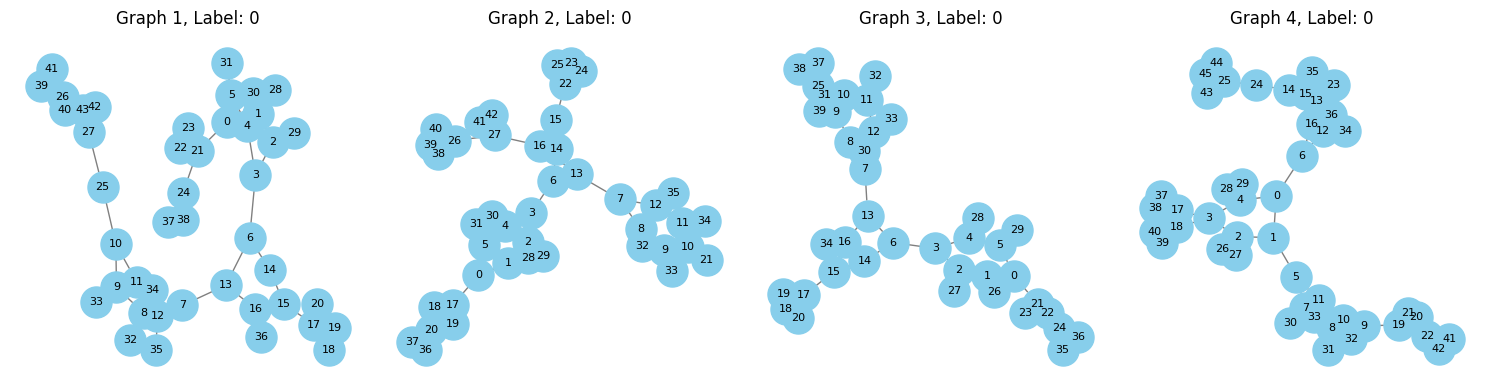

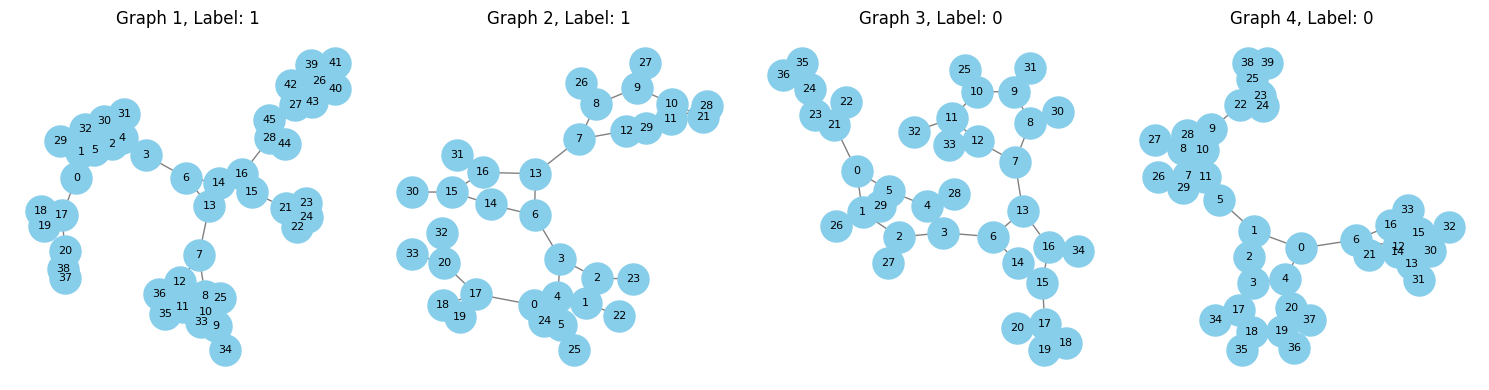

In [89]:
# Sample visualization from the dataloader
it = iter(train_loader)
for i, batch in enumerate(it):
    if i >=2: break
    batched_graph, labels = batch
    graphs = dgl.unbatch(batched_graph)
    labeled_graphs = list(zip(graphs, labels))
    visualize_graphs(labeled_graphs, num_samples=4)

## **3. GNN Model**

Here we want to establish the GNN model architechture to train the data. 2 types of architechture, GCN and GraphSAGE, are investigated with two different classifier heads (dense layer). 

Different from the tutorial, here we are using readout (global pooling) --> linear order in forward passing instead of linear --> readoout. This is because pooling node embeddings, then classifying means the classifier predicts based on the interpretation of the entire graph, instead of cosensus of each nodes.

In [90]:
import dgl.nn as dglnn

class GCN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, classifier_type='linear'):
        super(GCN_Classifier, self).__init__()
        # GNN layers
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.pool = dglnn.AvgPooling()
        
        # Classifier heads/dense layer
        self.classifier_type = classifier_type
        if classifier_type == 'linear':
            self.classifier = nn.Linear(hidden_dim, num_classes)
        else: #'mlp'
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim*2),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim*2, num_classes)
            )

    def forward(self, graph, node_features):
        h = nnF.relu(self.conv1(graph, node_features))
        h = nnF.relu(self.conv2(graph, h))
        h = nnF.dropout(h, 0.2)
        h_graph = self.pool(graph, h) # Global pooling
        logits = self.classifier(h_graph) # Output
        return logits

In [91]:
import dgl.nn as dglnn

class GraphSAGE_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, classifier_type='linear'):
        super(GraphSAGE_Classifier, self).__init__()
        # GNN layers
        self.conv1 = dglnn.SAGEConv(in_dim, hidden_dim, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(hidden_dim, hidden_dim, aggregator_type='pool')
        self.pool = dglnn.AvgPooling()

        # Classifier heads/dense layer
        self.classifier_type = classifier_type
        if classifier_type == 'linear':
            self.classifier = nn.Linear(hidden_dim, num_classes)
        else: #'mlp'
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim*2),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim*2, num_classes)
            )

    def forward(self, graph, node_features):
        h = nnF.relu(self.conv1(graph, node_features))
        h = nnF.relu(self.conv2(graph, h))
        h = nnF.dropout(h, 0.2)
        h_graph = self.pool(graph, h) # Global pooling
        logits = self.classifier(h_graph) # Output
        return logits

## **4. Training & Evaluation**

Here we want to establish the GNN model architechture to train the data. 2 types of architechture, GCN and GraphSAGE, are investigated with two different classifier heads (dense layer). 

Different from the tutorial, here we are using readout (global pooling) --> linear order in forward passing instead of linear --> readoout. This is because pooling node embeddings, then classifying means the classifier predicts based on the interpretation of the entire graph, instead of cosensus of each nodes.

In [92]:
# Training and evaluation function
def train_eval(model, train_loader, test_loader, epochs=30):
    # Loss & optimizer function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    # Return variables
    best_acc = 0
    train_accs, test_accs = [], []
    
    # Train model for N epochs
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for graphs, labels in train_loader: # Feed the training graphs batch by batch
            feats = graphs.ndata['node_attr'].float()
            logits = model(graphs, feats)
            loss = loss_fn(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()
        train_acc = correct / len(train_loader.dataset)
        train_accs.append(train_acc)
        
        # Evaluate epoch performance
        model.eval()
        correct = 0
        with torch.no_grad():
            for graphs, labels in test_loader:
                feats = graphs.ndata['node_attr'].float()
                logits = model(graphs, feats)
                correct += (logits.argmax(1) == labels).sum().item()
        test_acc = correct / len(test_loader.dataset)
        test_accs.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
        if (epoch+1)%5==0 or epoch+1==1:
            print(f"Epoch {epoch+1}; Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    return train_accs, test_accs, best_acc

In [93]:
# Evaluate function for f1 score and confusion matrix
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            graph, labels = batch
            graph = graph.to(device)
            labels = labels.to(device)
            feats = graph.ndata['node_attr'].float()
            logits = model(graph, feats)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [94]:
results = {}
best_accs = {}
in_dim = TUdataset[0][0].ndata['node_attr'].shape[1]
num_classes = TUdataset.num_labels


Training: GCN Classifier + LINEAR head
Trainable parameters: 4,546
Epoch 1; Loss: 3.6884, Train Acc: 0.6702, Test Acc: 0.7766
Epoch 5; Loss: 3.1260, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 10; Loss: 3.0996, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 15; Loss: 3.0675, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 20; Loss: 3.0741, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 25; Loss: 3.0174, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 30; Loss: 3.0230, Train Acc: 0.7828, Test Acc: 0.7766
F1 Score: 0.4371


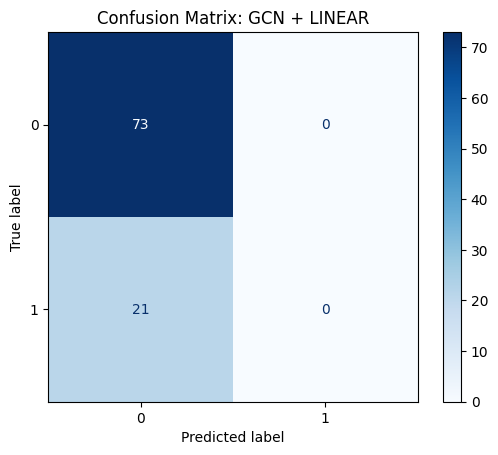


Training: GCN Classifier + MLP head
Trainable parameters: 12,994
Epoch 1; Loss: 3.3848, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 5; Loss: 3.2116, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 10; Loss: 3.1192, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 15; Loss: 3.0704, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 20; Loss: 3.1025, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 25; Loss: 2.9980, Train Acc: 0.7828, Test Acc: 0.7766
Epoch 30; Loss: 3.1984, Train Acc: 0.7828, Test Acc: 0.7766
F1 Score: 0.4371


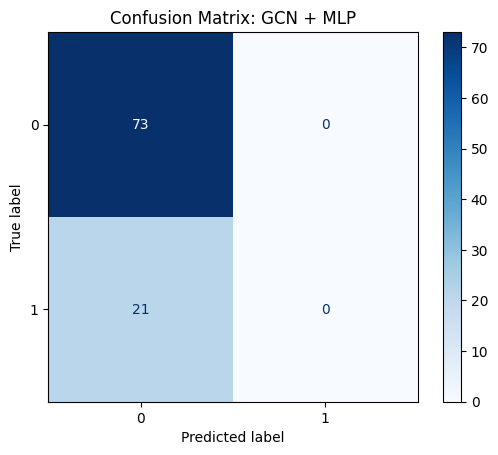

In [83]:
# Train GCN classifiers
for classifier_type in ['linear', 'mlp']:
    print(f"\nTraining: GCN Classifier + {classifier_type.upper()} head")
    GCN_model = GCN_Classifier(in_dim, hidden_dim=64, num_classes=num_classes, classifier_type=classifier_type)
    print(f"Trainable parameters: {sum(p.numel() for p in GCN_model.parameters() if p.requires_grad):,}")
    
    train_accs, test_accs, best_acc = train_eval(GCN_model, train_loader, test_loader)
    results["GCN"+classifier_type] = (train_accs, test_accs)
    best_accs["GCN"+classifier_type] = best_acc
    
    f1, cm = evaluate_model(GCN_model, test_loader)
    print(f"F1 Score: {f1:.4f}")

    # Visualize confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: GCN + {classifier_type.upper()}')
    plt.show()


Training: GraphSAGE Classifier + LINEAR head
Trainable parameters: 12,994
Epoch 1; Loss: 2.8108, Train Acc: 0.7989, Test Acc: 0.7660
Epoch 5; Loss: 2.5561, Train Acc: 0.8284, Test Acc: 0.7340
Epoch 10; Loss: 2.5352, Train Acc: 0.8231, Test Acc: 0.7447
Epoch 15; Loss: 2.4939, Train Acc: 0.8177, Test Acc: 0.7660
Epoch 20; Loss: 2.5290, Train Acc: 0.8204, Test Acc: 0.7872
Epoch 25; Loss: 2.3962, Train Acc: 0.8391, Test Acc: 0.7128
Epoch 30; Loss: 2.4090, Train Acc: 0.8284, Test Acc: 0.7340
F1 Score: 0.5104


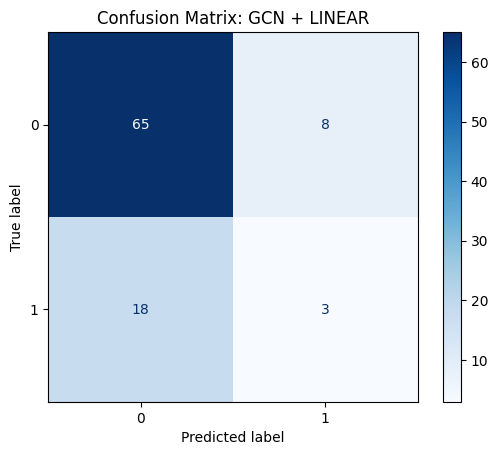


Training: GraphSAGE Classifier + MLP head
Trainable parameters: 21,442
Epoch 1; Loss: 2.8700, Train Acc: 0.7962, Test Acc: 0.7234
Epoch 5; Loss: 2.4934, Train Acc: 0.8177, Test Acc: 0.7128
Epoch 10; Loss: 2.3785, Train Acc: 0.8311, Test Acc: 0.7340
Epoch 15; Loss: 2.2626, Train Acc: 0.8391, Test Acc: 0.7234
Epoch 20; Loss: 2.4347, Train Acc: 0.8257, Test Acc: 0.7340
Epoch 25; Loss: 2.2063, Train Acc: 0.8445, Test Acc: 0.7234
Epoch 30; Loss: 2.3494, Train Acc: 0.8365, Test Acc: 0.7340
F1 Score: 0.5481


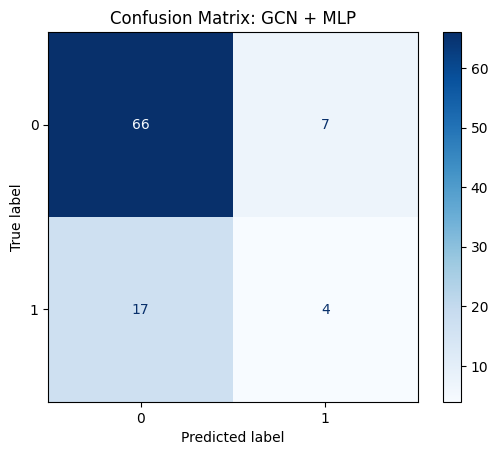

In [98]:
# Train GraphSAGE classifiers
for classifier_type in ['linear', 'mlp']:
    print(f"\nTraining: GraphSAGE Classifier + {classifier_type.upper()} head")
    GraphSAGE_model = GraphSAGE_Classifier(in_dim, hidden_dim=64, num_classes=num_classes, classifier_type=classifier_type)
    print(f"Trainable parameters: {sum(p.numel() for p in GraphSAGE_model.parameters() if p.requires_grad):,}")
    
    train_accs, test_accs, best_acc = train_eval(GCN_model, train_loader, test_loader)
    results["SAGE"+classifier_type] = (train_accs, test_accs)
    best_accs["SAGE"+classifier_type] = best_acc
    
    f1, cm = evaluate_model(GCN_model, test_loader)
    print(f"F1 Score: {f1:.4f}")

    # Visualize confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: GCN + {classifier_type.upper()}')
    plt.show()

* **Document your finding with described and visualised results**. 
* **Document behaviour/improvements of your architectures on specific examples.**

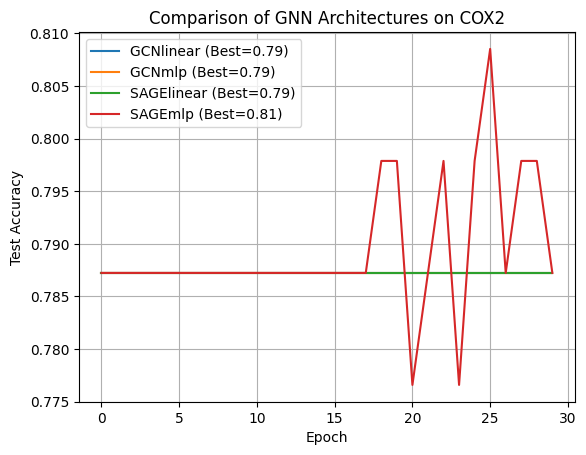

In [53]:
for architechture, (_, test_accs) in results.items():
    plt.plot(test_accs, label=f"{architechture} (Best={best_accs[architechture]:.2f})")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Comparison of GNN Architectures on COX2")
plt.legend()
plt.grid(True)
plt.show()

### **INTERPRETATION**
- **SAGE + MLP** achieved the highest test accuracy (~81%).
- **SAGE + MLP** has the best prediction for positive (label=1) label, with some tradeoff on negative label classification. 
- All **GCN** models has high false negative counts.

Overall, SAGE + MLP type architechture achieved the best performance among the tested model architechtures.  Convolution type has higher impact on the performance compared to the classifier head.